In [71]:
import warnings

warnings.filterwarnings("ignore")

import sys

if sys.version_info < (3,):
    raise Exception(
        "pytorch_toolkit does not support Python 2. Please use a Python 3+ interpreter!"
    )

import os
import sys
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# torch imports
import torch
import torch.nn as nn
import torchsummary as ts
import torch_training_toolkit as t3

SEED = 41
t3.seed_all(SEED)

# tweaking libraries
plt.rcParams["figure.figsize"] = (5, 4)
np.set_printoptions(suppress=True, precision=3, linewidth=110)
pd.set_option("display.float_format", "{:,.3f}".format)


print(
    f"Using Pytorch {torch.__version__}. GPU {'is available :)' if torch.cuda.is_available() else 'is not available :('}"
)
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else ("dml" if (hasattr(torch, "dml") and torch.dml.is_available()) else "cpu")
)
print(f"Will train models on {DEVICE}")

MODEL_SAVE_DIR = pathlib.Path(os.getcwd()) / "model_states"
print(f"Model state will be saved to {MODEL_SAVE_DIR}")
DATA_DIR = pathlib.Path(os.getcwd()) / "csv_files"

Using Pytorch 2.1.2+rocm5.6. GPU is not available :(
Will train models on cpu
Model state will be saved to /home/mjbhobe/code/git-projects/dl-pytorch/model_states


<Axes: xlabel='Month'>

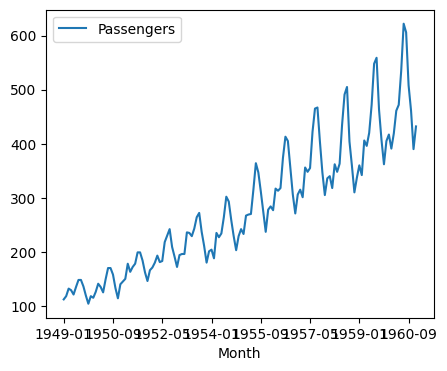

In [72]:
# load our data & plot it
target_file_name = DATA_DIR / "airline-passengers.csv"
df = pd.read_csv(target_file_name, index_col=0)
df[["Passengers"]].plot()

In [73]:
# split the data into train/test sets
# NOTE: for time-series we DO NOT shuffle the data
train_perc, val_perc = 0.90, 0.20  # 70%
train_size = int(len(df) * train_perc)

train_df, test_df = df[:train_size], df[train_size:]

val_size = int(train_size * 0.20)
train_size = train_size - val_size

train_df, val_df = train_df[:train_size], train_df[train_size:]

print(len(df), len(train_df), len(val_df), len(test_df))

144 104 25 15


In [74]:
def create_dataset(
    dataset: pd.DataFrame, lookback: int
) -> (torch.tensor, torch.tensor):
    sequences = []
    for i in range(len(dataset) - lookback):
        seq = dataset.iloc[i : i + lookback + 1].values
        sequences.append(seq)
    # take all-but-last element in X and last element in y for each sequence
    X, y = [seq[:-1] for seq in sequences], [seq[-1] for seq in sequences]
    y = np.expand_dims(y, axis=1)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [75]:
lookback = 1
X_train, y_train = create_dataset(train_df, lookback)
X_val, y_val = create_dataset(val_df, lookback)
X_test, y_test = create_dataset(test_df, lookback)
print(
    f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - "
    f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - "
    f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape}"
)

X_train.shape: torch.Size([103, 1, 1]) - y_train.shape: torch.Size([103, 1, 1]) - X_val.shape: torch.Size([24, 1, 1]) - y_val.shape: torch.Size([24, 1, 1]) - X_test.shape: torch.Size([14, 1, 1]) - y_test.shape: torch.Size([14, 1, 1])


In [76]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=50, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [90]:
# setup for training
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics


def rmse_error(preds, actuals):
    mse = torchmetrics.regression.MeanSquaredError()
    return torch.sqrt(mse(preds, actuals))


model = Model().to(DEVICE)
loss_fxn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = t3.Trainer(
    loss_fn=loss_fxn,
    device=DEVICE,
    epochs=2000,
    batch_size=8,
    metrics_map={"rmse": rmse_error},
)

train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
val_loader = DataLoader(TensorDataset(X_val, y_val), shuffle=False, batch_size=8)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=8)

In [91]:
hist = trainer.fit(
    model,
    optimizer,
    train_dataset=train_loader,
    validation_dataset=val_loader,
    seed=SEED,
)

Cross training on 'cpu' with 13 training and 3 cross-validation records...
Epoch (   1/2000): (103/13) -> loss: 58767.7849 - rmse: 229.1905 - val_loss: 160213.2135 - val_rmse: 397.4481
Epoch (   2/2000): (103/13) -> loss: 57150.8459 - rmse: 225.6655 - val_loss: 157454.0990 - val_rmse: 393.9589
Epoch (   3/2000): (103/13) -> loss: 55520.5454 - rmse: 222.0223 - val_loss: 154588.7344 - val_rmse: 390.3037
Epoch (   4/2000): (103/13) -> loss: 53978.2484 - rmse: 218.5085 - val_loss: 151897.8438 - val_rmse: 386.8391
Epoch (   5/2000): (103/13) -> loss: 52492.3030 - rmse: 215.0696 - val_loss: 149294.8646 - val_rmse: 383.4579
Epoch (   6/2000): (103/13) -> loss: 51066.1840 - rmse: 211.7168 - val_loss: 146776.5833 - val_rmse: 380.1581
Epoch (   7/2000): (103/13) -> loss: 49693.4976 - rmse: 208.4398 - val_loss: 144331.2656 - val_rmse: 376.9261
Epoch (   8/2000): (103/13) -> loss: 48367.6267 - rmse: 205.2258 - val_loss: 141949.3385 - val_rmse: 373.7511
Epoch (   9/2000): (103/13) -> loss: 47083.66

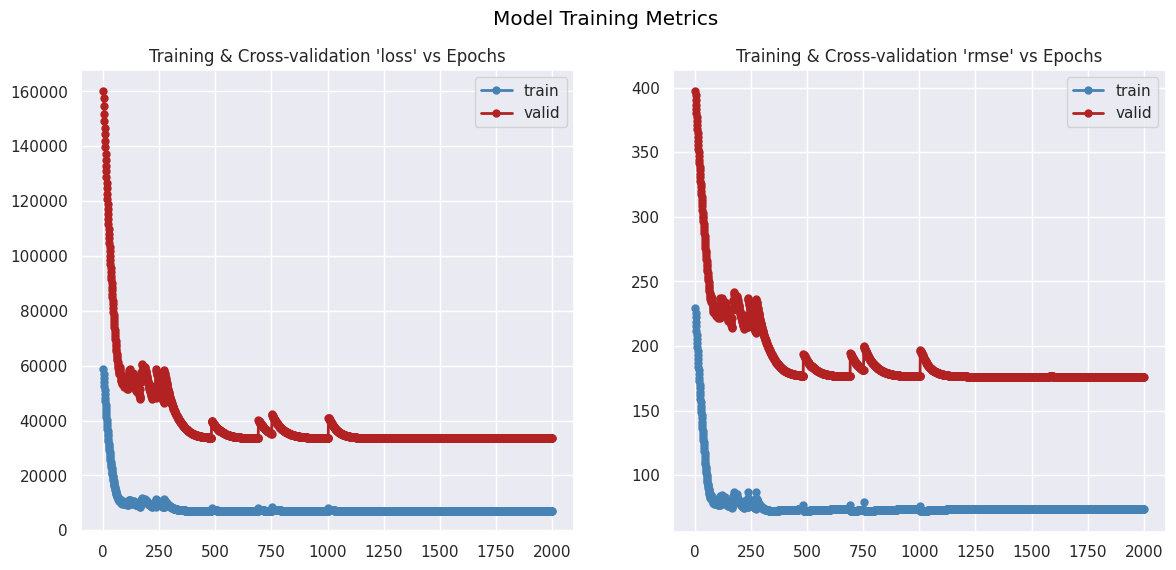

In [92]:
hist.plot_metrics(title="Model Training Metrics", fig_size=(14, 6))

In [105]:
# predictions
model.eval()
for X, y in test_loader:
    X = X.to(DEVICE)
    # y = y.to(DEVICE)
    y_pred = model(X)
    break

print(f"{y}\n{y_pred}")

tensor([[[362.]],

        [[405.]],

        [[417.]],

        [[391.]],

        [[419.]],

        [[461.]],

        [[472.]],

        [[535.]]])
tensor([[[229.0712]],

        [[229.0712]],

        [[229.0712]],

        [[229.0712]],

        [[229.0712]],

        [[229.0712]],

        [[229.0712]],

        [[229.0712]]], grad_fn=<ViewBackward0>)


In [103]:
preds.shape, actuals.shape

((14,), (14,))

In [104]:
print(f"{preds.ravel()}\n{actuals}")

[229.071 229.071 229.071 229.071 229.071 229.071 229.071 229.071 229.071 229.071 229.071 229.071 229.071
 229.071]
[362. 405. 417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]
